In [ ]:
#предварительно устанеавливаем необходимые библиотеки
#pip install pandas scikit-learn nltk spacy и ТД
#python -m spacy download ru_core_news_sm устанавливаем модель для обработки естественного языка
# Подключаем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gdown
import zipfile
import warnings
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, label_binarize
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import nltk
import spacy
import joblib

In [5]:
# Отключаем предупреждения
warnings.filterwarnings('ignore')

# Подготовка данных

In [120]:
df_primary = pd.DataFrame()
# Определяем типы необходимых записей для анализа
type_cols = {'Subject': 'string', 'code': 'string'}
# Читаем данные из CSV-файла частями, одновременно удаляя ненужные для анализа столбцы и строки с пустыми значениями.
with pd.read_csv("fz.csv", chunksize=300000, encoding='utf-8', on_bad_lines="skip", delimiter=',', header=None, usecols=[11, 26], names=['Subject', 'code'], dtype=type_cols) as reader:
  for chunk in reader:
    # Отфильтровываем записи о контрактах, оставляя записи групп ОКПД2 41, 42, 43, 71.1, 43.22
    chunk = chunk[(chunk['code'].str.len() <= 4) & (chunk['code'].str.contains('^41.') | chunk['code'].str.contains('^42.') | chunk['code'].str.contains('^43.') | chunk['code'].str.contains('^71.1')| chunk['code'].str.contains('^43.22'))]
    # Удаляем из датафрейма строки с неопределенным предметом закупки и строки с пустыми значениями
    chunk = chunk.loc[chunk['Subject'] != '<НЕ ОПРЕДЕЛЕНО>']
    chunk.dropna
    # Добавляем текущий chunk в итоговый датафрейм
    df_primary = pd.concat([df_primary, chunk], ignore_index=True)

In [121]:
# Создаем рабочий датафрейм
df_current = df_primary

In [122]:
# Сбрасываем индексы в датафрейме
df_current = df_current.reset_index()
del df_current['index']

# Предварительный анализ полученного датафрейма

In [123]:
# 20 случайных записей
df_current.sample(20)

,Subject,code
1564181,Выполнение монтажных работ по установке речево...,43.2
2434,Текущий ремонт помещений буфета ГБУ ЦРИ \Цариц...,41.2
1166897,Капитальный ремонт клапанных систем лечебного ...,42.2
420363,Разработка проектных решений для организации с...,71.1
1246542,Оказание услуг по разработке местных нормативо...,71.1
1377807,Выполнение работ по текущему ремонту туалетов ...,43.9
1688025,№ зз-22634-2022 Монтаж системы пожарной сигнал...,43.2
583351,Установка и замена дорожных знаков на улицах г...,42.1
27408,Выполнение работ по устройству искусственного ...,42.9
248494,Выполнение работ по выкашиванию участков газон...,42.1


In [124]:
# Проверяем  размер датафрейма
df_current.shape

(1764006, 2)

In [125]:
# Выводим типы данных хранящихся в датафрейме
df_current.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764006 entries, 0 to 1764005
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   Subject  string
 1   code     string
dtypes: string(2)
memory usage: 26.9 MB


In [126]:
# Количество записей, сгруппированных по коду ОКПД2
df_current.groupby('code', as_index=False).agg({'Subject':'count'})

,code,Subject
0,41.1,12708
1,41.2,197730
2,42.1,386497
3,42.2,57455
4,42.9,110079
5,43.1,35840
6,43.2,311580
7,43.3,199705
8,43.9,200305
9,71.1,252107


# !

In [ ]:
#n = 300000
#df_current = df_current.sample(n)
#Для тестовых испытаний кода я ограничивал размер используемой части датасета, в финальном варианте лемматизация и обучение были проведены на всем датасете

# Лемматизация описания закупки

In [127]:
# Загружаем русскую модель spaCy
nlp_Subject = spacy.load('ru_core_news_sm')

In [128]:
# Определим функцию для лемматизации предмета закупки
def lem_def(text_Subject):
  doc = nlp_Subject(text_Subject)
  return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

In [129]:
# Провордим лемматизацию столбца с описанием закупки - 
tqdm.pandas(desc="Выполняется лемматизация описания закупки")
df_current['lem_Subject'] = df_current['Subject'].progress_apply(lem_def)

Выполняется лемматизация описания закупки: 100%|██████████| 1764006/1764006 [5:04:10<00:00, 96.66it/s]   


In [130]:
# Ручное заполнение словаря кодов ОКПД2 и соответствующих им рубрик классификатора в соответствии с заданием
OKPD2_dictionary = {
    '41.1': 'Документация проектная для строительства',
    '41.2': 'Здания и работы по возведению зданий',
    '42.1': 'Дороги автомобильные и железные; строительные работы по строительству автомобильных дорог и железных дорог',
    '42.2': 'Сооружения и строительные работы по строительству инженерных коммуникаций',
    '42.9': 'Сооружения и строительные работы по строительству прочих гражданских сооружений',
    '43.1': 'Работы по сносу зданий и сооружений и по подготовке строительного участка',
    '43.2': 'Работы электромонтажные; работы по монтажу водопроводных и канализационных систем и прочие строительно-монтажные работы',
    '43.3': 'Работы завершающие и отделочные в зданиях и сооружениях',
    '43.9': 'Работы строительные специализированные прочие',
    '71.1': 'Услуги в области архитектуры, инженерно-технического проектирования и связанные технические консультативные услуги',
    '43.22': 'Работы по монтажу систем водопровода, канализации, отопления и кондиционирования воздуха'
}

In [132]:
# Определим функцию для преобразования кодов ОКПД2 в текстовые метки рубрик классификатора
def convert_OKPD2_to_text_labels(code_OKPD2):
  return [OKPD2_dictionary.get(c) for c in str(code_OKPD2).split(',') if c in OKPD2_dictionary]

In [133]:
# Создадим словарь рубрик классификатора и соответствующих им кодов ОКПД2
Labels_to_OKPD2 = {v: k for k, v in OKPD2_dictionary.items()}

In [134]:
# Промаркируем датафрейм метками рубрик
df_current['text_Labels'] = df_current['code'].apply(convert_OKPD2_to_text_labels)

# Преобразование текстовых меток в бинарный формат

In [135]:
# Для многоклассовой классификации используем бинарное представление текстовых меток рубрик
mlb_Labels = MultiLabelBinarizer()
y = mlb_Labels.fit_transform(df_current['text_Labels'])

# Разделение данных на обучающую и тестовую выборки

In [136]:
# Зададим размер обучающей выборки в 80%, тестовой выборки - 20%
X_train, X_test, y_train, y_test = train_test_split(df_current['lem_Subject'], y, test_size=0.2, random_state=42)

# Создание модели обучения

In [137]:
# Используем TfidfVectorizer для преобразования текста в числовые вектора
tfidf = TfidfVectorizer(max_features=10000)

In [155]:
# метод опорных векторов
# model = OneVsRestClassifier(CalibratedClassifierCV(LinearSVC()))
# наивный байесовский классификатор
# model = OneVsRestClassifier(MultinomialNB())
# XGBoost. 
# model = MultiOutputClassifier(XGBClassifier(n_estimators=100, random_state=42))
# многозадачная классификация
model = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(10), max_iter=100, random_state=42))
# метод логистической регрессии
## model = MultiOutputClassifier(LogisticRegression(max_iter=1000))
# случайный лес
# model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
# градиентный бустинг
# model = MultiOutputClassifier(GradientBoostingClassifier(n_estimators=100, random_state=42))

In [156]:
# Построим пайплайн модели обучения
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clsf', model)
])

# Обучение модели на обучающей выборке

In [157]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=10000)),
                ('clsf',
                 MultiOutputClassifier(estimator=MLPClassifier(hidden_layer_sizes=10,
                                                               max_iter=100,
                                                               random_state=42)))])

# Оценка модели

In [158]:
# Обучающая выборка
train_predictions = pipeline.predict(X_train)
train_report = classification_report(y_train, train_predictions, target_names=mlb_Labels.classes_)
train_accuracy = accuracy_score(y_train, train_predictions)
print("Метрики оценки качества на обучающей выборке:")
print(train_report)
print(f"Точность на обучающей выборке равна {train_accuracy:.2f}")

Метрики оценки качества на обучающей выборке:
                                                                                                                         precision    recall  f1-score   support

                                                                               Документация проектная для строительства       0.83      0.45      0.59     10132
             Дороги автомобильные и железные; строительные работы по строительству автомобильных дорог и железных дорог       0.97      0.97      0.97    309129
                                                                                   Здания и работы по возведению зданий       0.90      0.72      0.80    158201
                                                                Работы завершающие и отделочные в зданиях и сооружениях       0.82      0.78      0.80    159845
                                              Работы по сносу зданий и сооружений и по подготовке строительного участка       0.94      0.85      0.

In [159]:
# Тестовая выборка
test_predictions = pipeline.predict(X_test)
test_report = classification_report(y_test, test_predictions, target_names=mlb_Labels.classes_)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Метрики оценки качества на тестовой выборке:")
print(test_report)
print(f"Точность на тестовой выборке равна {test_accuracy:.2f}")

Метрики оценки качества на тестовой выборке:
                                                                                                                         precision    recall  f1-score   support

                                                                               Документация проектная для строительства       0.53      0.27      0.36      2576
             Дороги автомобильные и железные; строительные работы по строительству автомобильных дорог и железных дорог       0.94      0.94      0.94     77368
                                                                                   Здания и работы по возведению зданий       0.82      0.66      0.73     39529
                                                                Работы завершающие и отделочные в зданиях и сооружениях       0.73      0.69      0.71     39860
                                              Работы по сносу зданий и сооружений и по подготовке строительного участка       0.88      0.77      0.8

# Построение ROC-кривой и вычисление AUC

In [160]:
# Определим функцию для вывода кривой ROC и показателя AUC
def draw_roc_auc(y_true, y_pred, title):
  fig, ax = plt.subplots(figsize=(8, 6))
  for i in range(y_true.shape[1]):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    auc_score = roc_auc_score(y_true[:, i], y_pred[:, i])
    label = f'{mlb_Labels.classes_[i]} (ОКПД2: {Labels_to_OKPD2[mlb_Labels.classes_[i]]}) (AUC = {auc_score:.2f})'
    ax.plot(fpr, tpr, label=label)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title(title)
  ax.legend(bbox_to_anchor=(-0.1, -0.1), loc='upper left', prop={'size': 7})
  plt.show()

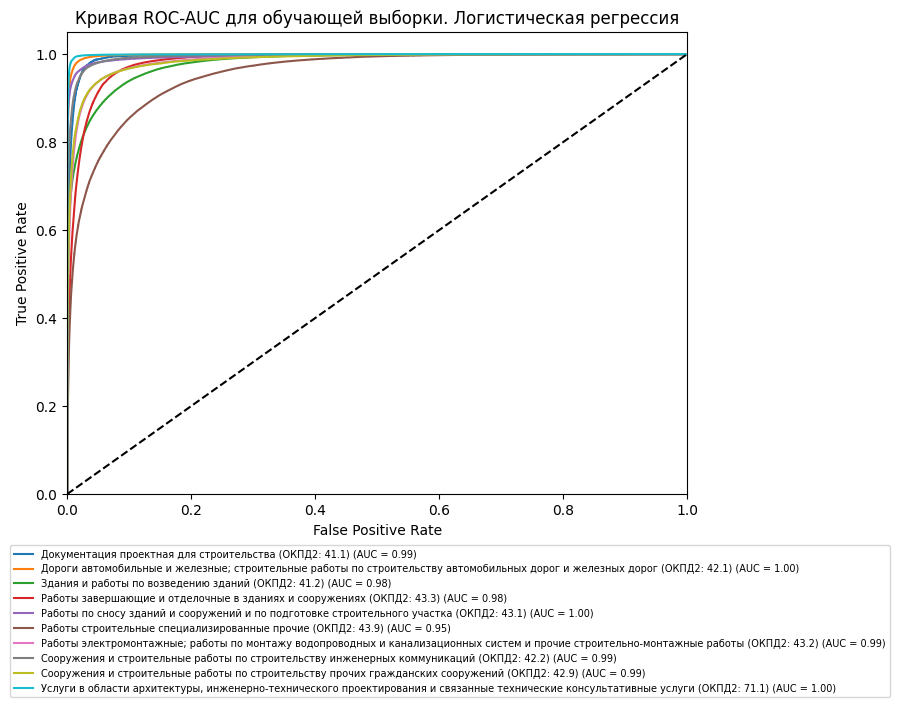

In [161]:
# Кривая ROC-AUC для обучающей выборки
# train_probabilities = pipeline.predict_proba(X_train) # график для SVM и NB
train_probabilities = np.array([x[:, 1] for x in pipeline.predict_proba(X_train)]).T # график для других моделей
draw_roc_auc(y_train, train_probabilities, 'Кривая ROC-AUC для обучающей выборки. Логистическая регрессия')

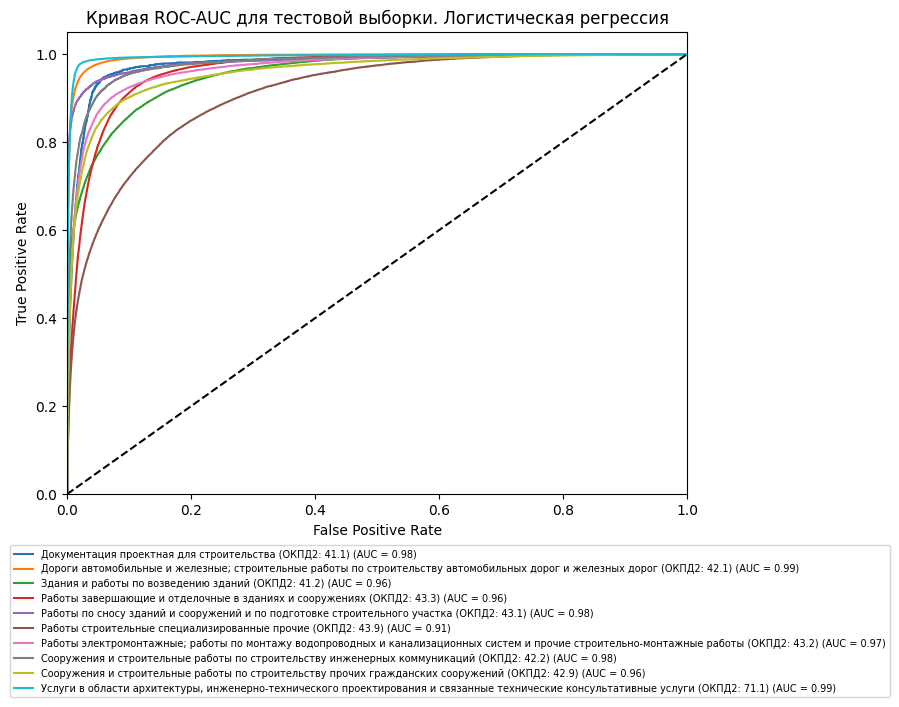

In [162]:
# Кривая ROC-AUC для тестовой выборки
# test_probabilities = pipeline.predict_proba(X_test) # график для SVM и NB
test_probabilities = np.array([x[:, 1] for x in pipeline.predict_proba(X_test)]).T # график для других моделей
draw_roc_auc(y_test, test_probabilities, 'Кривая ROC-AUC для тестовой выборки. Логистическая регрессия')

# Сохранение модели

In [163]:
joblib.dump(pipeline, 'fz_class_model.pkl')

['fz_class_model.pkl']

# Применение модели

In [164]:
# Загружаем сохраненную модель
pipeline = joblib.load('fz_class_model.pkl')

In [165]:
# Определим функцию для классификации нового контракта
def class_contract(Subject_GZ):
  lemmatized_Subject = lem_def(Subject_GZ)
  prediction = pipeline.predict([lemmatized_Subject])
  labels = mlb_Labels.inverse_transform(prediction)
  return labels[0]

# Тест готовой модели

In [170]:
test_contract = "Технологическое подключение к сетям водоотведения быстровозводимого модульного здания пожарного депо"
predicted_Subject = class_contract(test_contract)
if len(predicted_Subject) != 0:
  for key in Labels_to_OKPD2:
    if key == predicted_Subject[0]:
      predicted_OKPD2 = Labels_to_OKPD2[key]
      print(f"Результат классификации: ОКПД2 - {predicted_OKPD2}, рубрика - {predicted_Subject[0]}")
else: print(f"Закупка '{test_contract}' не классифицирована")

Результат классификации: ОКПД2 - 43.2, рубрика - Работы электромонтажные; работы по монтажу водопроводных и канализационных систем и прочие строительно-монтажные работы
